In [155]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [157]:
import _pickle as cPickle

from helper import PeriodicAccumulator
from itertools import product

In [158]:
def get(n_syn, g_factor, cycle_dur, g_S, alpha, beta, r_max):
    return cPickle.load(open('results/sine_task_n_syn_{0}_g_factor_{1}_cycle_dur_{2}_g_S_{3}_alpha_{4}_beta_{5}_r_max_{6}.p'.format(
        n_syn, g_factor, cycle_dur, g_S, alpha, beta, r_max),'rb'))

n_syn_s     = [str(a) for a in [100]]
g_factor_s  = [str(a) for a in [100]]
cycle_dur_s = [str(a) for a in [100]]
g_S_s       = [str(a) for a in [0.0]]
alpha_s     = [str(a) for a in [-55.0]]
beta_s      = [str(a) for a in [0.25]]
r_max_s     = [str(a) for a in [0.35]]


params = list(product(n_syn_s, g_factor_s, cycle_dur_s, g_S_s, alpha_s, beta_s, r_max_s))

data = {tup:get(*tup) for tup in params}

In [159]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

In [160]:
def show_plot(key, n_syn, g_factor, cycle_dur, g_S, alpha, beta, r_max, y_c, t_min, t_max):
    plt.figure(figsize=(12,5))
    p = (n_syn, g_factor, cycle_dur, g_S, alpha, beta, r_max)
    ts = data[params[-1]][1][0].t
    mask = np.logical_and(ts>=t_min, ts<=t_max)
    if key=='y':
        plt.plot(data[0][1][0].t[mask],
                 data[0][1][0].res[key][mask, :int(y_c)+1])
    else:
        plt.plot(data[p][1][0].t[mask],
                 data[p][1][0].res[key][mask])

In [161]:
ts = data[params[-1]][1][0].t
# 0~3400を0.05刻み?

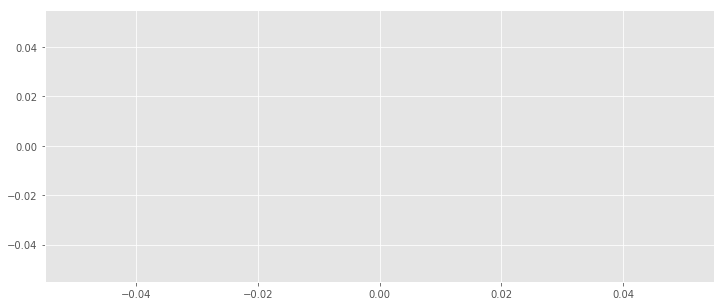

In [162]:
ts = data[params[-1]][1][0].t
i = interact(show_plot,
    key = widgets.ToggleButtons(description='key',
                                options=['dendr_pred',
                                         'weights',
                                         'weight_updates', 
                                         'PIVs', 
                                         'y',
                                         'h']),
    t_min = (0, int(np.round(ts[-1]))),
    t_max = (0, int(np.round(ts[-1]))),
    n_syn    = widgets.ToggleButtons(description='n_syn',    options=n_syn_s),
    g_factor = widgets.ToggleButtons(description='g_factor', options=g_factor_s),
    cycle_dur= widgets.ToggleButtons(description='cycle_dur',options=cycle_dur_s),
    g_S      = widgets.ToggleButtons(description='g_S',      options=g_S_s),
    alpha    = widgets.ToggleButtons(description='alpha',    options=alpha_s),
    beta     = widgets.ToggleButtons(description='beta',     options=beta_s),
    r_max    = widgets.ToggleButtons(description='r_max',    options=r_max_s),
    y_c      = widgets.ToggleButtons(description='y_c',      options=[str(a) for a in range(5)]))

In [163]:
epochs   = 4
l_c      = 6
eval_c   = 2
cycles   = epochs * l_c + (epochs + 1) * eval_c
#..G_FACTOR = 100
G_FACTOR = 100
E_E      = 0.0
E_I      = -75.0

In [179]:
def exc_soma_cond(t, cycle_dur):
    t_end = cycles * cycle_dur
    #return ((1 + np.sin(np.pi / 2 + t / t_end * cycles * 2 * np.pi)) * 7e-3 * 1 + 7e-3) * G_FACTOR
    return ((1 + np.sin(np.pi / 2 + t / t_end * cycles * 2 * np.pi)) * 2e-3 * 1 + 8e-3) * G_FACTOR

def inh_soma_cond(t):
    #return 4e-2 * G_FACTOR
    return 8e-2 * G_FACTOR
    
def match_pot(t, c_d=100):
    return (exc_soma_cond(t, c_d) * E_E + inh_soma_cond(t) * E_I) / (exc_soma_cond(t, c_d) + inh_soma_cond(t))

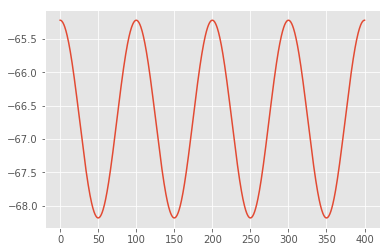

In [186]:
ts = np.linspace(0,400,1000)
plt.plot(ts, list(map(match_pot, ts)))
plt.show()

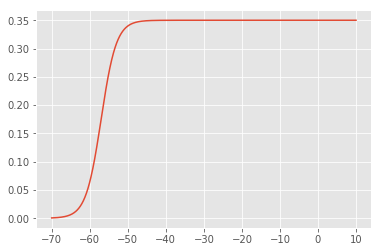

In [181]:
def phi(v, alpha, beta, r_max):
    return r_max / (1 + np.exp(-beta * (v - alpha)))

vs = np.linspace(-70, 10, 1000)
plt.plot(vs, list(map(lambda v: phi(v, -57, 0.5, 0.35), vs)))
plt.show()

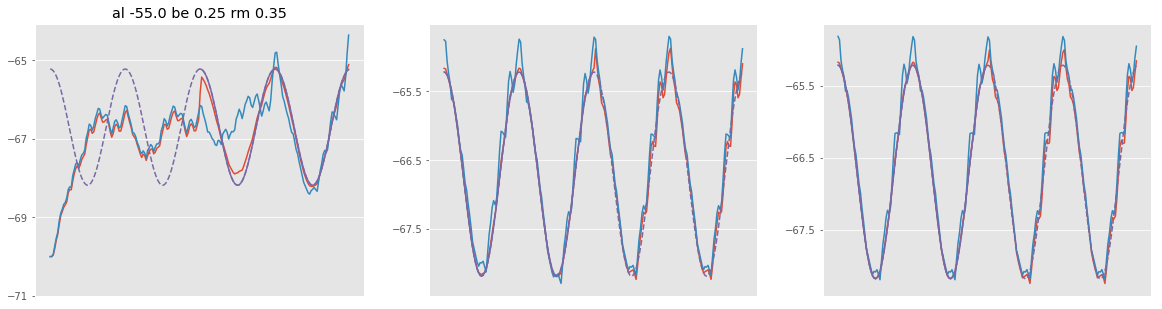

In [185]:
phi_combs = list(product(alpha_s, beta_s, r_max_s))

for g_S in g_S_s:
    for n_syn in n_syn_s:
        for cycle_dur in cycle_dur_s:
            c_d = int(cycle_dur)
            epoch_dur = c_d * (l_c + eval_c)
            plt.figure(figsize = (20,5))
            
            for phi_idx, phi_comb in enumerate(phi_combs):
                alpha, beta, r_max = phi_comb
                p = (n_syn, str(G_FACTOR), cycle_dur, g_S, alpha, beta, r_max,)
                curr = data[p][1][0]               
                
                epochs_show = [2,4]
                plt.subplot(len(phi_combs), len(epochs_show)+1, phi_idx*(len(epochs_show)+1) + 1)
                mask = curr.t < (eval_c+2) * c_d
                plt.plot(curr.t[mask], curr.res['y'][mask, :2])
                plt.plot(curr.t[mask], match_pot(curr.t[mask], c_d), '--', c='#7A68A6')
                mask = np.logical_and(mask, curr.t > eval_c*c_d)
                plt.plot(curr.t[mask], match_pot(curr.t[mask], c_d), c='#7A68A6')
                plt.yticks(plt.yticks()[0][::2])
                plt.xticks([])
                plt.title('al {0} be {1} rm {2}'.format(alpha, beta, r_max))
                
                for epoch_idx, epoch in enumerate(epochs_show):
                    plt.subplot(len(phi_combs), 
                                len(epochs_show)+1, 
                                phi_idx*(len(epochs_show)+1) + epoch_idx +2)
                    mask =                      curr.t > epoch * epoch_dur - 2 * c_d
                    mask = np.logical_and(mask, curr.t < epoch * epoch_dur + 2 * c_d)
                    
                    # 青とオレンジのライン
                    plt.plot(curr.t[mask], curr.res['y'][mask, :2])                             
                    plt.yticks(plt.yticks()[0][::2])
                    # 紫のラインの破線部分
                    plt.plot(curr.t[mask], match_pot(curr.t[mask], c_d), '--', c='#7A68A6')                             
                    mask = np.logical_and(mask, curr.t < epoch * epoch_dur)
                    # 紫のラインの実線部分
                    plt.plot(curr.t[mask], match_pot(curr.t[mask], c_d),       c='#7A68A6')                             
                    plt.xticks([])